### Imports

In [31]:
import warnings
warnings.filterwarnings("ignore")

# 데이터 조작
import pandas as pd
import numpy as np
from itertools import combinations as c

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
#%config InlineBackend.figure_format = "retina"

# 자체로 만든 모듈(파일에 포함되어 있습니다.)
from fqtoolkit import dgToDf as dtd

# 머신러닝
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import classification_report

import statsmodels.api as sm
from scipy.stats import norm

### Data 불러오기

In [32]:
assets, liability, sale, income, price = [item[1] for item in dtd("data2.xlsx", "Sheet1", 5).items()]

### Asset과 Liability를 변화량으로 치환

In [33]:
assets0 = assets.pct_change()
liability0 = liability.pct_change()

In [34]:
# asset, liability value는 12개월간 변하지 않으므로, 
# 가장 최근 주어진 변화율로 0을 채움.
assets0 = assets0.where(assets0 != 0, np.nan)
assets0 = assets0.fillna(method="ffill")

liability0 = liability0.where(liability0 != 0, np.nan)
liability0 = liability0.fillna(method="ffill")

In [35]:
#shift를 통해 정보를 실제로 얻는 시점까지 미룸

assets0 = assets0.shift(12+6)
liability0 = liability0.shift(12+6)
sale = sale.shift(12+6)
income = income.shift(12+6)

### Data 정보 확인

In [36]:
assets0.tail()

,삼성전자,LG에너지솔루션,SK하이닉스,삼성바이오로직스,NAVER,삼성SDI,현대차,카카오,LG화학,기아,...,네이처셀,주성엔지니어링,SFA반도체,덕산네오룩스,메가스터디교육,NICE평가정보,피엔티,케어젠,와이지엔터테인먼트,에이비엘바이오
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2022-01-31,0.072813,NaN,0.090815,0.086706,0.383325,0.084733,0.076252,0.368161,0.216447,0.092974,...,-0.07905,0.234474,-0.112947,0.21842,0.280042,0.155824,-0.12972,-0.065953,0.051265,-0.300962
2022-02-28,0.072813,NaN,0.090815,0.086706,0.383325,0.084733,0.076252,0.368161,0.216447,0.092974,...,-0.07905,0.234474,-0.112947,0.21842,0.280042,0.155824,-0.12972,-0.065953,0.051265,-0.300962
2022-03-31,0.072813,NaN,0.090815,0.086706,0.383325,0.084733,0.076252,0.368161,0.216447,0.092974,...,-0.07905,0.234474,-0.112947,0.21842,0.280042,0.155824,-0.12972,-0.065953,0.051265,-0.300962
2022-04-30,0.072813,NaN,0.090815,0.086706,0.383325,0.084733,0.076252,0.368161,0.216447,0.092974,...,-0.07905,0.234474,-0.112947,0.21842,0.280042,0.155824,-0.12972,-0.065953,0.051265,-0.300962
2022-05-16,0.072813,NaN,0.090815,0.086706,0.383325,0.084733,0.076252,0.368161,0.216447,0.092974,...,-0.07905,0.234474,-0.112947,0.21842,0.280042,0.155824,-0.12972,-0.065953,0.051265,-0.300962


In [37]:
income.tail()

,삼성전자,LG에너지솔루션,SK하이닉스,삼성바이오로직스,NAVER,삼성SDI,현대차,카카오,LG화학,기아,...,네이처셀,주성엔지니어링,SFA반도체,덕산네오룩스,메가스터디교육,NICE평가정보,피엔티,케어젠,와이지엔터테인먼트,에이비엘바이오
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2022-01-31,35993876000,-475206000,5012624000,292786554.08,1215342457.28,671335358.43,2394671000,455855515,1805359000,2066457000,...,-6410732.43,-25033172.72,34282018.13,40112481.93,32815677.16,62718416.76,55300226.03,31977802.91,5993837.72,-59647069
2022-02-28,35993876000,-475206000,5012624000,292786554.08,1215342457.28,671335358.43,2394671000,455855515,1805359000,2066457000,...,-6410732.43,-25033172.72,34282018.13,40112481.93,32815677.16,62718416.76,55300226.03,31977802.91,5993837.72,-59647069
2022-03-31,35993876000,-475206000,5012624000,292786554.08,1215342457.28,671335358.43,2394671000,455855515,1805359000,2066457000,...,-6410732.43,-25033172.72,34282018.13,40112481.93,32815677.16,62718416.76,55300226.03,31977802.91,5993837.72,-59647069
2022-04-30,35993876000,-475206000,5012624000,292786554.08,1215342457.28,671335358.43,2394671000,455855515,1805359000,2066457000,...,-6410732.43,-25033172.72,34282018.13,40112481.93,32815677.16,62718416.76,55300226.03,31977802.91,5993837.72,-59647069
2022-05-16,35993876000,-475206000,5012624000,292786554.08,1215342457.28,671335358.43,2394671000,455855515,1805359000,2066457000,...,-6410732.43,-25033172.72,34282018.13,40112481.93,32815677.16,62718416.76,55300226.03,31977802.91,5993837.72,-59647069


In [38]:
price.head()

,삼성전자,LG에너지솔루션,SK하이닉스,삼성바이오로직스,NAVER,삼성SDI,현대차,카카오,LG화학,기아,...,네이처셀,주성엔지니어링,SFA반도체,덕산네오룩스,메가스터디교육,NICE평가정보,피엔티,케어젠,와이지엔터테인먼트,에이비엘바이오
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2000-01-31,3910,NaN,462551,NaN,NaN,33804,10835,20556,NaN,4742,...,4572,36388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-29,3588,NaN,313624,NaN,NaN,24992,7635,31130,NaN,3155,...,6949,46388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-31,4695,NaN,431013,NaN,NaN,31145,8491,17342,NaN,3529,...,11704,35048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04-30,4204,NaN,308367,NaN,NaN,35171,6622,8882,NaN,3557,...,10789,31986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05-31,4316,NaN,308367,NaN,NaN,32664,7667,13636,NaN,4361,...,6931,22914,NaN,NaN,NaN,1075,NaN,NaN,NaN,NaN


In [39]:
sale.tail()

,삼성전자,LG에너지솔루션,SK하이닉스,삼성바이오로직스,NAVER,삼성SDI,현대차,카카오,LG화학,기아,...,네이처셀,주성엔지니어링,SFA반도체,덕산네오룩스,메가스터디교육,NICE평가정보,피엔티,케어젠,와이지엔터테인먼트,에이비엘바이오
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2022-01-31,236806988000,1461068000,31900418000,1164776873.64,5304145900.39,11294770446.040001,103997601000,4156816120.72,30058872000,59168096000,...,16719797.4,118545864.75,573077540.34,144162647.18,474716713.89,446005796.02,390049983.36,60295113.42,255262402.3,8104203.46
2022-02-28,236806988000,1461068000,31900418000,1164776873.64,5304145900.39,11294770446.040001,103997601000,4156816120.72,30058872000,59168096000,...,16719797.4,118545864.75,573077540.34,144162647.18,474716713.89,446005796.02,390049983.36,60295113.42,255262402.3,8104203.46
2022-03-31,236806988000,1461068000,31900418000,1164776873.64,5304145900.39,11294770446.040001,103997601000,4156816120.72,30058872000,59168096000,...,16719797.4,118545864.75,573077540.34,144162647.18,474716713.89,446005796.02,390049983.36,60295113.42,255262402.3,8104203.46
2022-04-30,236806988000,1461068000,31900418000,1164776873.64,5304145900.39,11294770446.040001,103997601000,4156816120.72,30058872000,59168096000,...,16719797.4,118545864.75,573077540.34,144162647.18,474716713.89,446005796.02,390049983.36,60295113.42,255262402.3,8104203.46
2022-05-16,236806988000,1461068000,31900418000,1164776873.64,5304145900.39,11294770446.040001,103997601000,4156816120.72,30058872000,59168096000,...,16719797.4,118545864.75,573077540.34,144162647.18,474716713.89,446005796.02,390049983.36,60295113.42,255262402.3,8104203.46


In [40]:
#price = price.dropna(axis=1)
returns = price.pct_change()
returns = price.shift(0).pct_change()
returns0 = price.shift(0).pct_change()
returns.head(20)

,삼성전자,LG에너지솔루션,SK하이닉스,삼성바이오로직스,NAVER,삼성SDI,현대차,카카오,LG화학,기아,...,네이처셀,주성엔지니어링,SFA반도체,덕산네오룩스,메가스터디교육,NICE평가정보,피엔티,케어젠,와이지엔터테인먼트,에이비엘바이오
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2000-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-29,-0.082353,NaN,-0.321969,NaN,NaN,-0.260679,-0.295339,0.514400,NaN,-0.334669,...,0.519904,0.274816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-31,0.308528,NaN,0.374299,NaN,NaN,0.246199,0.112115,-0.442917,NaN,0.118542,...,0.684271,-0.244460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04-30,-0.104579,NaN,-0.284553,NaN,NaN,0.129266,-0.220115,-0.487833,NaN,0.007934,...,-0.078178,-0.087366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05-31,0.026641,NaN,0.000000,NaN,NaN,-0.071280,0.157807,0.535240,NaN,0.226033,...,-0.357586,-0.283624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-06-30,0.199722,NaN,0.250001,NaN,NaN,0.255939,0.181818,0.315195,NaN,0.035772,...,0.266484,0.054159,NaN,NaN,NaN,-0.246512,NaN,NaN,NaN,NaN
2000-07-31,-0.200463,NaN,-0.209091,NaN,NaN,-0.078515,0.045470,-0.326419,NaN,0.124862,...,-0.406243,-0.457172,NaN,NaN,NaN,0.272840,NaN,NaN,NaN,NaN
2000-08-31,-0.072947,NaN,0.166668,NaN,NaN,0.004074,0.123720,-0.030795,NaN,-0.062389,...,0.449156,-0.094646,NaN,NaN,NaN,-0.270611,NaN,NaN,NaN,NaN
2000-09-30,-0.261334,NaN,-0.214286,NaN,NaN,-0.109097,-0.136872,-0.158951,NaN,-0.096348,...,-0.268767,-0.417404,NaN,NaN,NaN,-0.174202,NaN,NaN,NaN,NaN


## 최적 Max Depth 찾는 과정

- 기대수익률 추정을 위해서는 **Decision Tree**가 사용됨
- 아래의 알고리즘은 Decision Tree의 Parameter중 하나인 Max Depth를 찾는 과정이다.
- For 문을 통해 Max Depth를 조절하며 **Validation**에서 가장 좋은 성능을 발휘하는 Max Depth를 찾는다.
- 이 과정은 구간을 움직이며(Rolling) 학습 데이터를 업데이트한다.
- 즉, 가장 최근의 학습 데이터의 바로 다음 달의 기대수익률을 추정하는 방식이다.
- 각각의 학습에서 Data Leakage가 없으므로, 이렇게 계산된 기대수익과 실제 수익 간의 차이를 통해 만든 펀더멘털 괴리도를 가지고 다시 모형을 만들 수 있다.
- 이 과정에서 과거 펀더멘털 괴리도의 평균과 표준편차를 이용하였고, 표준화한 편더멘터 괴리도를 트레이딩 시그널로 사용하였다.
- 검증 Metric은 $R^2$을 사용하였다.

In [41]:
results = {}
r2 = []
Max_Depth = 0
Depth = 0

for maxD in range(1,20):
    for col in returns.columns:
        reSeries = {}
        for n in range(1, returns.shape[0]-152):
            #n부터 n+1**까지의 롤링 데이터 준비
            temp = pd.DataFrame({"asset":assets0[col].iloc[n:n+151], #n시점의 총자산 변화율
                                "liability":liability0[col].iloc[n:n+151], #n시점의 총부채 변화율
                                "sale":sale[col].iloc[n:n+151], #n시점의 매출액
                                "income":income[col].iloc[n:n+151], #n시점의 영업이익
                                 "re0": returns[col].iloc[n-1:n+150], #n-1시점의 종목 수익률
                                "re": returns[col].iloc[n:n+151]}) #n시점의 종목 수익률

            temp = temp.dropna() # 데이터 결측치 제거
            
            if temp.shape[0] < 50: #만약 결측치를 제거하였을 때도 길이가 50보다 작을 경우, signal 생성을 하지 않음
                continue

            model = DecisionTreeRegressor(max_depth=maxD, random_state=10)
            model.fit(temp.drop("re", axis=1).iloc[:-1,:], temp["re"].iloc[:-1]) #현재 수익률 추정 모형 fitting
            r = model.predict(temp.drop("re", axis=1).iloc[[-1], :]) #현재 시점의 추정 수익률 계산
            reSeries[temp.index[-1]] = temp["re"].iloc[-1]-r[0] #현재 시점의 추정오차 저장

            if len(reSeries) > 0: #추정오차 데이터가 있는 경우만 signal 저장
                results[col] = pd.Series(reSeries) 


    results = pd.DataFrame(results) #시그널 데이터프레임화
    signal = (results).mean(axis=1) #종목별 시그널 통합

    temp = pd.DataFrame({"returns":returns.shift(-1).mean(axis=1), "result":signal}).dropna() #성능 측정용 데이터 준비
    test = temp.iloc[int(temp.shape[0]/4):2*int(temp.shape[0]/4), :] #validation set
    test0 = temp.iloc[2*int(temp.shape[0]/4):, :] #test set

    mu = temp.result.iloc[:int(temp.shape[0]/4)].mean() #training set에서의 signal 평균
    sd = temp.result.iloc[:int(temp.shape[0]/4)].std() #training set에서의 signal 표준편차

    test.result = (test.result-mu)/sd #training set 평균 표준편차를 이용한 정규화
    test0.result = (test0.result-mu)/sd #training set 평균 표준편차를 이용한 정규화
    
    r2_Depth = np.corrcoef(test.returns, -test.result)[1,0 ] ** 2 * 100
    
    if r2_Depth > Max_Depth:
        Max_Depth = r2_Depth
        Depth = maxD

    # signal과 미래 수익률 간의 R Squared 측정
    
    r2.append(np.corrcoef(test.returns, -test.result)[1,0 ] ** 2 )
    print(f"{np.corrcoef(test.returns, -test.result)[1,0 ] ** 2 * 100:.4f}%")
print(Depth, Max_Depth)

0.8662%
0.0736%
5.8728%
31.5541%
20.1392%
17.5281%
11.5188%
7.2093%
4.0760%
17.3316%
7.8009%
8.1464%
8.1498%
8.1498%
8.1498%
8.1498%
8.1498%
8.1498%
8.1498%
4 31.554088511165734


### Max Depth에 따른 $R^2$ 변화 시각화

Font 'default' does not have a glyph for '\uc5d0' [U+c5d0], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\ub530' [U+b530], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\ub978' [U+b978], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\ubcc0' [U+bcc0], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\ud654' [U+d654], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\uc5d0' [U+c5d0], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\ub530' [U+b530], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\ub978' [U+b978], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\ubcc0' [U+bcc0], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\ud654' [U+d654], substituting with a dummy symbol.


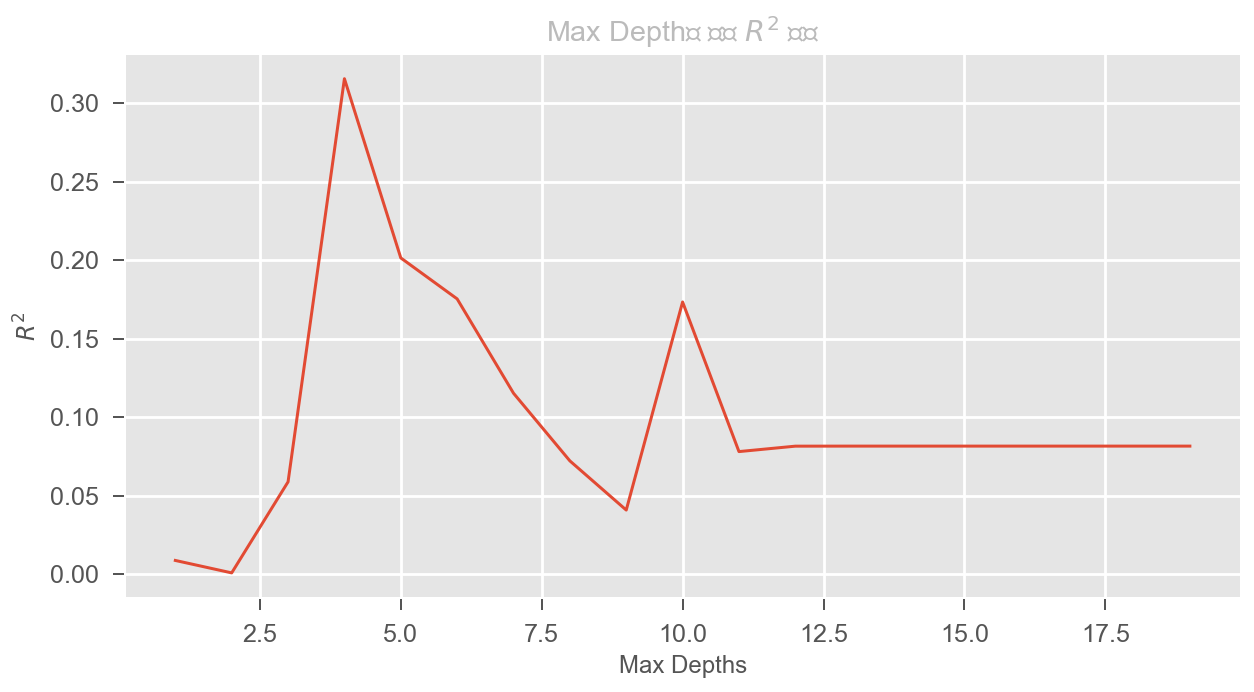

In [42]:
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.title('Max Depth에 따른 $R^2$ 변화')
plt.xlabel("Max Depths")
plt.ylabel("$R^2$")
plt.plot(list(range(1, 20)), r2)
plt.show();

### 통계검정을 위한 데이터셋 분할과 전략 구상

- Vailidation에서 레이블 0(하락)에 대한 예측은 잘 들이맞지 않았다.
- 따라서, 상승할 경우만 예측하고 하락할 것으로 예측할 경우는 매매를 하지 않는 전략을 사용한다. 
- 투자 가중치로는 표준화된 펀더멘털 괴리도를 그대로 사용한다.

### 위의 그래프에서 가장 높은 $R^2$ 값을 가지는 Max Depth 값 사용

In [45]:
maxD =4
results = {}

for col in returns.columns:
    reSeries = {}
    for n in range(1, returns.shape[0]-152):

            #n부터 n+120까지의 롤링 데이터 준비
        temp = pd.DataFrame({"asset":assets0[col].iloc[n:n+151],
                                "liability":liability0[col].iloc[n:n+151],
                                "sale":sale[col].iloc[n:n+151],
                                "income":income[col].iloc[n:n+151],
                                 "re0": returns[col].iloc[n-1:n+150],
                                "re": returns[col].iloc[n:n+151]})
        temp = temp.dropna()

        if temp.shape[0] < 50:
            continue

        model = DecisionTreeRegressor(max_depth=maxD, random_state=10)#
        model.fit(temp.drop("re", axis=1).iloc[:-1,:], temp["re"].iloc[:-1])
        r = model.predict(temp.drop("re", axis=1).iloc[[-1], :])
        reSeries[temp.index[-1]] = temp["re"].iloc[-1]-r[0]

        if len(reSeries) > 0:
            results[col] = pd.Series(reSeries)

### 상승할 경우만 예측하고 하락할 것으로 예측할 경우는 매매를 하지 않는 전략

In [48]:
results = pd.DataFrame(results)

signal = (results).mean(axis=1)

temp = pd.DataFrame({"returns":returns.shift(-1).mean(axis=1), "result":signal}).dropna() #전략 생성을 위한 시그널과 수익률 날짜맞춤
test = temp.iloc[int(temp.shape[0]/4):2*int(temp.shape[0]/4), :] #validation set 생성
test0 = temp.iloc[2*int(temp.shape[0]/4):, :] #test set생성

#training set에서 평균과 표준편차 추출
mu = temp.result.iloc[:int(temp.shape[0]/4)].mean() 
sd = temp.result.iloc[:int(temp.shape[0]/4)].std()

#표준화
test.result = (test.result-mu)/sd
#표준화
test0.result = (test0.result-mu)/sd
# 시그널을 이용한 전략 수익률을 생성
test["port"] = test["returns"]* np.where( test.result< 0, -test.result, 0)
test0["port"] = test0["returns"] * np.where( test0.result< 0, -test0.result, 0) 

print(f"{np.corrcoef(test.returns, -test.result)[1,0 ] ** 2 * 100:.4f}%")
print(classification_report(np.where(test.returns> 0, 1, 0), np.where(-test.result >0, 1, 0)))

31.5541%
              precision    recall  f1-score   support

           0       0.54      0.88      0.67         8
           1       0.94      0.71      0.81        21

    accuracy                           0.76        29
   macro avg       0.74      0.79      0.74        29
weighted avg       0.83      0.76      0.77        29



In [18]:
tVals = []
ports = {} #각 종목에서의 전략 수행 결과 기록용 딕셔너리

for col in results.columns:
    
    #종목별로 위의 과정을 거침
    
    temp = pd.DataFrame({"returns":returns.shift(-1)[col], "result":results[col]}).dropna()
    test = temp.iloc[int(temp.shape[0]/4):2*int(temp.shape[0]/4), :]
    test0 = temp.iloc[2*int(temp.shape[0]/4):, :]

    mu = temp.result.iloc[:int(temp.shape[0]/4)].mean()
    sd = temp.result.iloc[:int(temp.shape[0]/4)].std()

    test.result = (test.result-mu)/sd
    test0.result = (test0.result-mu)/sd

    test["port"] = test["returns"]* np.where( test.result< 0, -test.result, 0)#
    test0["port"] = test0["returns"] * np.where( test0.result< 0, -test0.result, 0)
    
    ports[col] = test0["port"] #종목별 전략 성과 저장

In [19]:
ports = pd.DataFrame(ports)
ports.head()

,삼성전자,SK하이닉스,삼성바이오로직스,NAVER,삼성SDI,현대차,카카오,LG화학,기아,POSCO홀딩스,...,안랩,네이처셀,주성엔지니어링,SFA반도체,덕산네오룩스,메가스터디교육,NICE평가정보,피엔티,케어젠,와이지엔터테인먼트
2017-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-31,0.000000,0.000000,NaN,-0.009106,0.000000,-0.014558,0.000000,-0.037660,-0.000000,0.000000,...,-0.059333,0.0,0.000000,0.000000,NaN,NaN,-0.006435,NaN,NaN,NaN
2017-06-30,0.001232,-0.000000,NaN,-0.049605,-0.018235,-0.000000,0.000000,0.000000,-0.042778,0.000000,...,0.030651,0.0,0.000000,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN
2017-07-31,-0.074570,0.000000,NaN,-0.089918,0.067247,-0.000000,0.029069,0.256015,-0.015373,0.041242,...,-0.000000,0.0,0.000000,-0.216664,NaN,NaN,-0.000000,NaN,NaN,NaN
2017-08-31,0.000133,0.093178,NaN,-0.009595,0.019976,0.013965,0.000000,0.036032,-0.000000,-0.007592,...,-0.000000,-0.0,-0.086918,-0.002989,NaN,NaN,0.027371,NaN,NaN,NaN


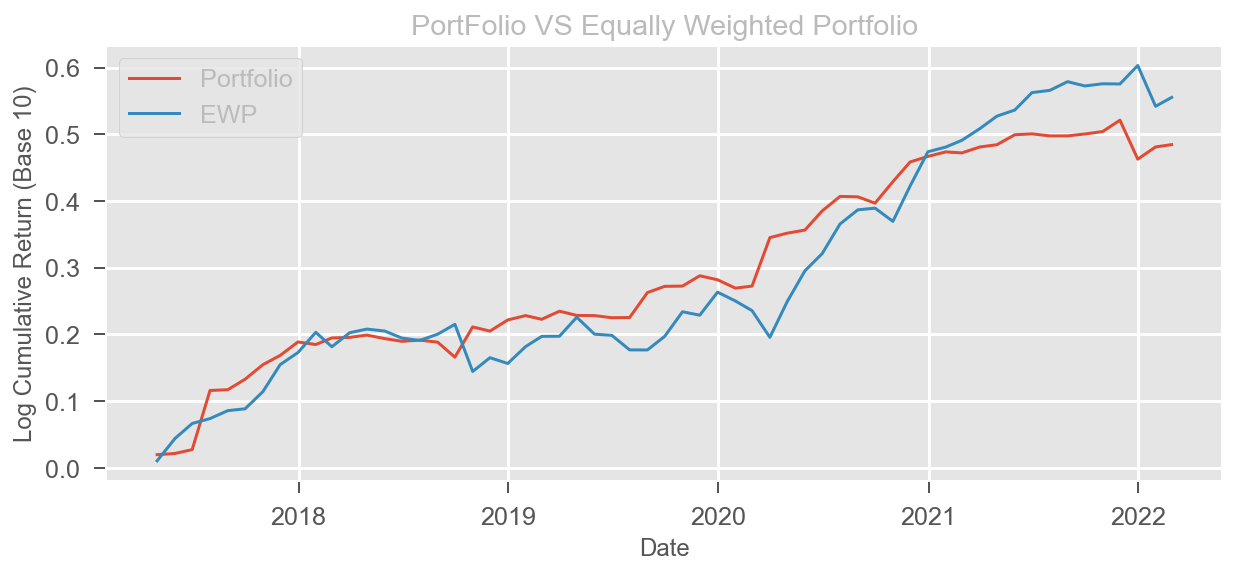

In [49]:
plt.figure(figsize=(10, 4))
plt.title('PortFolio VS Equally Weighted Portfolio')
plt.xlabel("Date")
plt.ylabel("Log Cumulative Return (Base 10)")
plt.plot(np.log10((1+ports.mean(axis=1)).cumprod()), label="Portfolio")
plt.plot(np.log10((1+returns.loc[ports.index, :].mean(axis=1)).cumprod()), label="EWP")
plt.legend();

In [21]:
P = ports.mean(axis=1)
EWP = returns.loc[ports.index, :].mean(axis=1)

P = P[:'2019']
EWP = EWP[:'2019']

result = {"Portfolio":[P.mean(), P.std(), P.mean()/P.std(), np.percentile(P, 5)], 
          "EWP":[EWP.mean(), EWP.std(), EWP.mean()/EWP.std(), np.percentile(EWP, 5)]}

result = pd.DataFrame(result).T

result.columns = ["Mean", "SD", "Sharpe Ratio", "5 Percentile"]
result.iloc[:, [0,1 ,3]] = (np.round(result.iloc[:, [0,1 ,3]]*100, 2)).astype(str) + "%"

result["Sharpe Ratio"] = np.round(result["Sharpe Ratio"], 2)

result

,Mean,SD,Sharpe Ratio,5 Percentile
Portfolio,2.09%,4.86%,0.43,-1.44%
EWP,1.98%,5.1%,0.39,-5.21%


In [22]:
np.mean(P -EWP)

0.001074462164223179

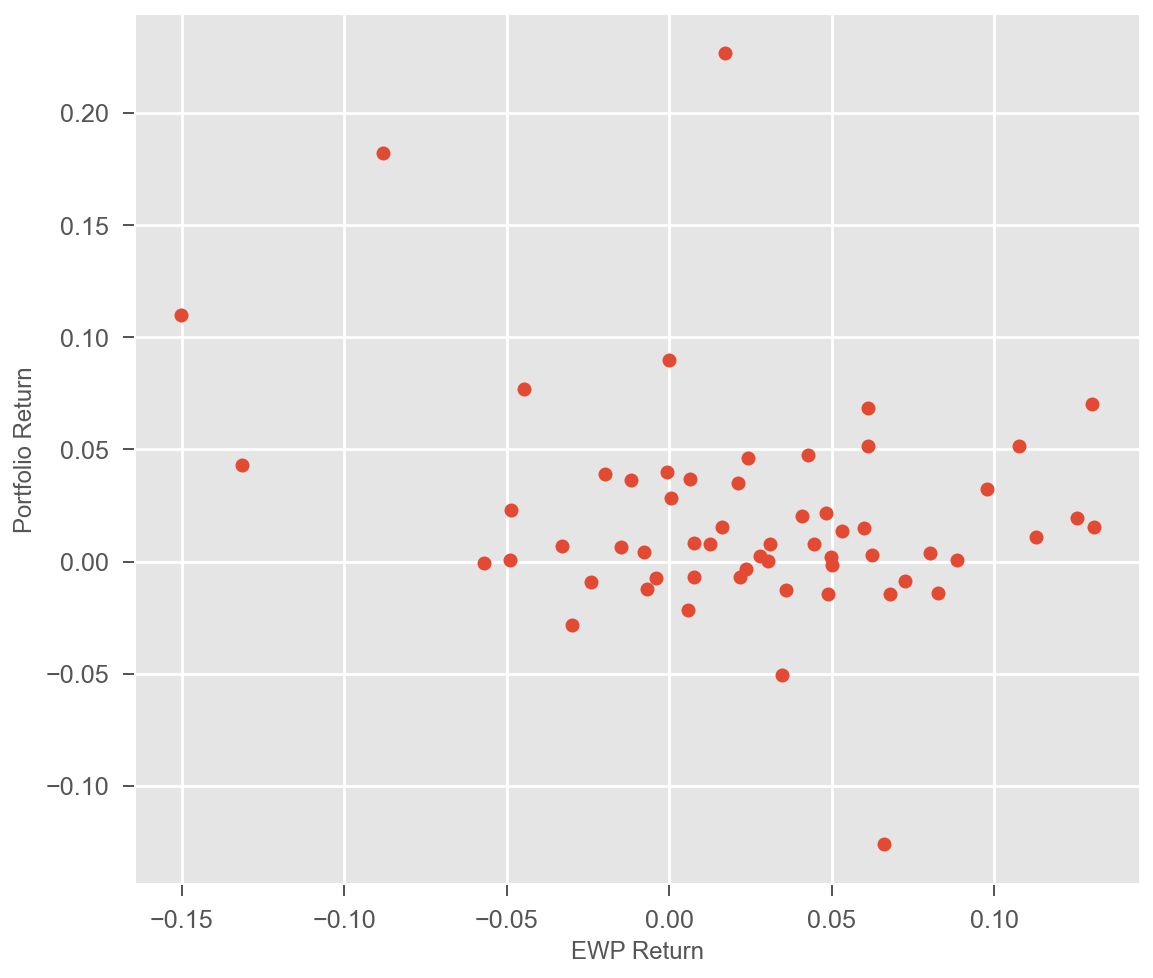

In [23]:
plt.figure(figsize=(9, 8))
plt.xlabel("EWP Return")
plt.ylabel("Portfolio Return")
plt.plot(returns.loc[ports.index, :].mean(axis=1), ports.mean(axis=1), "o");

In [24]:
#전략 유의성 검증 분석용 변수들 설정
test = pd.DataFrame({"port":ports.mean(axis=1), "market":returns.loc[ports.index, :].mean(axis=1)}).dropna() 
test["market+"] = np.where(test["market"] > 0,test["market"] , 0 ) #가상 옵션 수익률 생성.
test.head()

,port,market,market+
2017-04-30,0.046258,0.024179,0.024179
2017-05-31,0.004036,0.080085,0.080085
2017-06-30,0.013460,0.053266,0.053266
2017-07-31,0.226540,0.017088,0.017088
2017-08-31,0.002646,0.027830,0.027830


### CAPM 기반 통계검정

In [25]:
sm.OLS(test["port"], sm.add_constant(test[["market"]])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   port   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     3.971
Date:                Thu, 23 Jun 2022   Prob (F-statistic):             0.0511
Time:                        03:26:57   Log-Likelihood:                 96.405
No. Observations:                  59   AIC:                            -188.8
Df Residuals:                      57   BIC:                            -184.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0254      0.007      3.749      0.000       0.012       0.039
market        -0.2206      0.111     -1.993      0.051      -0.442       0.001
==============================================================================
Omnibus:                       31.649   Durbin-Watson:                   1.855
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.544
Skew:                           1.426   Prob(JB):                     1.99e-23
Kurtosis:                       8.864   Cond. No.                         17.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### - Result 
- 상수항이 0.05의 유의수준에서 통계적으로 유의하게 0보다 큼.
- **즉, 시장의 움직임과 다른 초과수익이 발생.**

### HM 시점선택 모형 기반 시점선택 능력 평가

- EWP가 하락할 때 베타를 줄이고, EWP가 상승할 때 베타를 늘어나는지 확인한다.

In [26]:
sm.OLS(test["port"], sm.add_constant(test[["market", "market+"]])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   port   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     3.521
Date:                Thu, 23 Jun 2022   Prob (F-statistic):             0.0363
Time:                        03:26:57   Log-Likelihood:                 97.913
No. Observations:                  59   AIC:                            -189.8
Df Residuals:                      56   BIC:                            -183.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0128      0.010      1.288      0.203      -0.007       0.033
market        -0.5569      0.224     -2.482      0.016      -1.006      -0.107
market+        0.5741      0.335      1.714      0.092      -0.097       1.245
==============================================================================
Omnibus:                       36.397   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              161.008
Skew:                           1.540   Prob(JB):                     1.09e-35
Kurtosis:                      10.484   Cond. No.                         63.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### market+ 변수의 회귀계수가 통계적으로 유의: 유의미한 시점선택이 이루어지고 있음을 의미한다.

## 비모수 시점선택 통계검정

주가 급상승기에 모수 검정법이 통하지 않을 경우를 대비해 생성.

In [27]:

def estimation(bench, port):
    n0 = 0
    n = 0
    for t1, t2, t3 in c(range(len(bench)), 3):
        n0 += 1
        rms = bench.iloc[[t1, t2, t3]].sort_values()
        trueT1, trueT2, trueT3 = rms.index
        betaH = (port.loc[trueT3] - port.loc[trueT2]) / (bench.loc[trueT3] - bench.loc[trueT2])
        betaL = (port.loc[trueT2] - port.loc[trueT1]) / (bench.loc[trueT2] - bench.loc[trueT1])
        
        if betaH > betaL:     
            n += 1
            
    return 2*(n / n0) -1
         
def kernel(rms, ris):
    rm1, rm2, rm3 = rms
    ri1, ri2, ri3 = ris
    
    premise = rm1 < rm2 and rm2 < rm3
    
    if not premise:    
        return 0
    
    betaH = (ri3 - ri2) / (rm3 - rm2)      
    betaL = (ri2 - ri1) / (rm2 - rm1) 
    conclusion = betaH > betaL 
    
    if  premise and not conclusion:  
        return 0
    else:   
        return 1
    
def stanardE(bench, port, esti):
    sum0 = 0
    for t1 in bench.index:    
        sum1 = 0   
        n0 = 0  
        for t2, t3 in c(bench.index, 2):     
            n0 += 1    
            sum1 += kernel(bench.loc[[t1, t2, t3]], port.loc[[t1, t2, t3]])
            
        sum1 = (sum1 / n0 - esti) ** 2   
        sum0 += sum1

    var = 9 / len(bench.index) * sum0
    
    return np.sqrt(var)

def nonParaMT(bench, port):
    esti = estimation(bench, port)
    se = stanardE(bench, port, esti)
    statistic = esti * np.sqrt(len(bench)) /se
    pVal = 1 - norm.cdf(statistic, loc=0, scale=1)
    
    return esti, se , statistic, pVal

In [28]:
nonParaMT(test["market"], test["port"])

(0.11870558922144636,
 0.272601377588335,
 3.3447920915259792,
 0.00041172136062050946)

## Result
### 비모수 방법으로도 통계적으로 유의한 결과가 도출하였다.